# Chapter 4 - Classification

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline

BASE_DIR = 'https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/master/Notebooks'

## 1. Analyze Data
### 1.1. Load *Default* dataset
Dataset Description: https://rdrr.io/cran/ISLR/man/Default.html

In [2]:
df = pd.read_excel(f'{BASE_DIR}/Data/Default.xlsx')
df.head(3)

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947


### 1.2. Preprocess Data

In [3]:
# factorize() returns two objects: a label array and an array with the unique values
df['default'], target_names = df['default'].factorize()
df['student'], _ = df['student'].factorize()

print('Target names:', target_names)
df.head(3)

Target names: Index(['No', 'Yes'], dtype='object')


,Unnamed: 0,default,student,balance,income
0,1,0,0,729.526495,44361.625074
1,2,0,1,817.180407,12106.134700
2,3,0,0,1073.549164,31767.138947


### 1.3. Plot Data

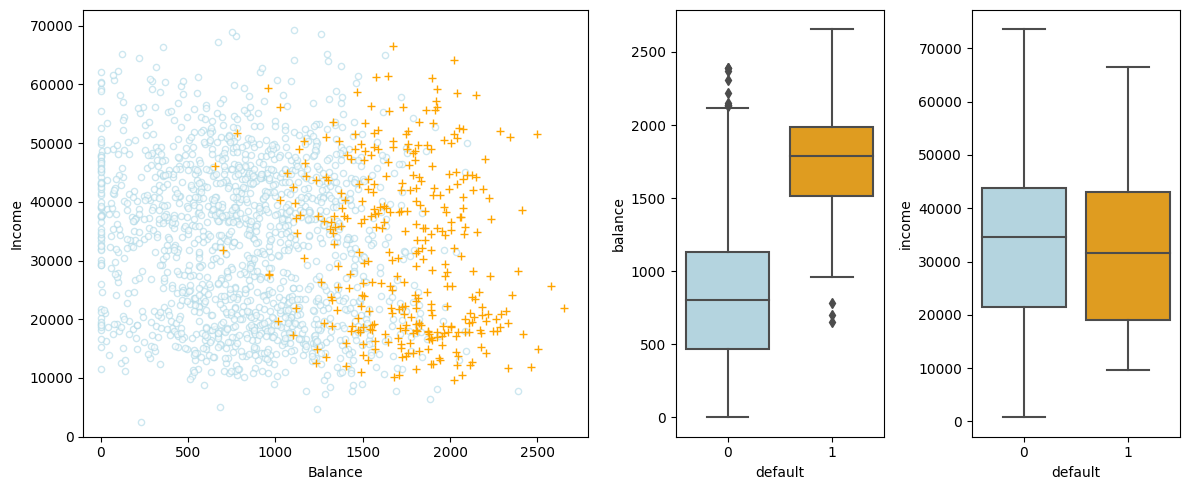

In [4]:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df['default'] == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df['default'] == 1]

ax1.scatter(df_no['balance'], df_no['income'], s=20, edgecolors='lightblue', facecolors='white', marker='o', linewidths=1, alpha=.6)
ax1.scatter(df_yes['balance'], df_yes['income'], s=40, c='orange', marker='+', linewidths=1)

ax1.set_xlim(xmin=-100)
ax1.set_ylim(ymin=0)
ax1.set_xlabel('Balance')
ax1.set_ylabel('Income')

c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(df, x='default', y='balance', orient='v', ax=ax2, palette=c_palette)
sns.boxplot(df, x='default', y='income', orient='v', ax=ax3, palette=c_palette)

fig.tight_layout()
fig.show()

### 1.4. Exercise
Write your code in the cells below. (10min)<br/>
Dataset Description: https://rdrr.io/cran/ISLR/man/Smarket.html
1. Load `f'{BASE_DIR}/Data/Smarket.csv'` data with `pd.read_csv()`
2. Factorize 'Direction' Column
3. Plot Data with 'Lag1', 'Lag2' predictors

In [5]:
# 1. Load f'{BASE_DIR}/Data/Smarket.csv' data with pd.read_csv() method

df = pd.read_csv(f'{BASE_DIR}/Data/Smarket.csv',)
df.head(3)

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down


In [6]:
# 2. Factorize 'Direction' Column

df['Direction'], target_names = df['Direction'].factorize()
print(target_names)
df.head(3)

Index(['Up', 'Down'], dtype='object')


,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,0
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,0
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,1


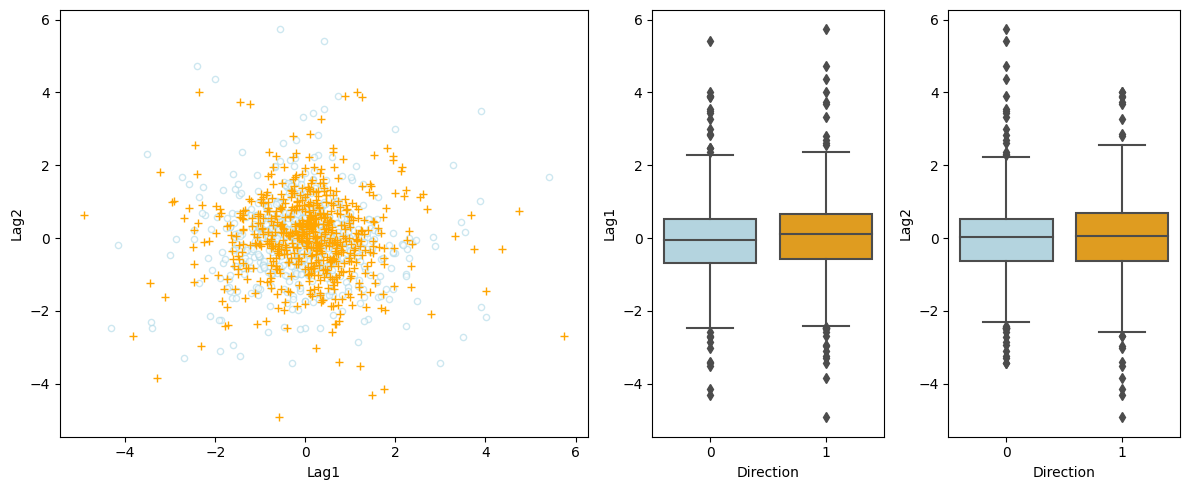

In [7]:
# 3. Plot Data with 'Lag1', 'Lag2' predictors for each direction

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (Direction) is 'Up'
df_up = df[df['Direction'] == 0]
# Take all samples where target value is 'Down'
df_down = df[df['Direction'] == 1]

ax1.scatter(df_up['Lag1'], df_up['Lag2'], s=20, edgecolors='lightblue', facecolors='white', marker='o', linewidths=1, alpha=.6)
ax1.scatter(df_down['Lag1'], df_down['Lag2'], s=40, c='orange', marker='+', linewidths=1)

ax1.set_xlabel('Lag1')
ax1.set_ylabel('Lag2')

c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(df, x='Direction', y='Lag1', orient='v', ax=ax2, palette=c_palette)
sns.boxplot(df, x='Direction', y='Lag2', orient='v', ax=ax3, palette=c_palette)

fig.tight_layout()
fig.show()

## 2. Logistic Regression
### 2.1. Predict Default with Balance

In [8]:
# Load and factorize data
df = pd.read_excel(f'{BASE_DIR}/Data/Default.xlsx')
df['default'], target_names = df['default'].factorize()
df['student'], _ = df['student'].factorize()

# Select X, Y
X_train = df[['balance']]
y_train = df['default']

# Train Logistic Regression Model
clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

# Predict Y with trained model
y_pred = clf.predict(X_train)
y_true = y_train

print(y_true, y_pred)

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: default, Length: 10000, dtype: int64 [0 0 0 ... 0 0 0]


### 2.2. Analyze the Result

In [9]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      9667
         Yes       0.70      0.30      0.42       333

    accuracy                           0.97     10000
   macro avg       0.84      0.65      0.70     10000
weighted avg       0.97      0.97      0.97     10000



In [10]:
print(confusion_matrix(y_true, y_pred))

[[9625   42]
 [ 233  100]]


              precision    recall  f1-score   support

          No       0.98      1.00      0.99      9667
         Yes       0.70      0.30      0.42       333

    accuracy                           0.97     10000
   macro avg       0.84      0.65      0.70     10000
weighted avg       0.97      0.97      0.97     10000



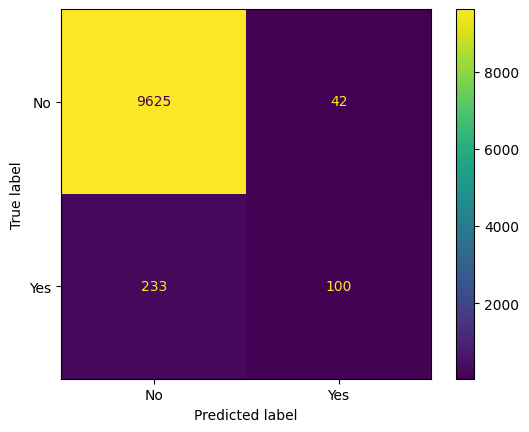

In [11]:
print(classification_report(y_true, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names)

### 2.3. Exercise
Write your code in the cells below. (10min)
1. Load f'{BASE_DIR}/Data/Smarket.csv' data with pd.read_csv() method
2. Factorize 'Direction' Column
3. Predict Up/Down of the Smarket with your own predictors
4. Analyze the Result

In [12]:
# 1. Load f'{BASE_DIR}/Data/Smarket.csv' data with pd.read_csv() method

df = pd.read_csv(f'{BASE_DIR}/Data/Smarket.csv')
df.head(3)

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down


In [13]:
# 2. Factorize 'Direction' Column

df['Direction'], target_names = df['Direction'].factorize()
print(target_names)
df.head(3)

Index(['Up', 'Down'], dtype='object')


,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,0
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,0
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,1


In [14]:
# 3. Predict Up/Down of the Smarket with your own predictors

X_train = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
y_train = df['Direction']

clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_true = y_train

              precision    recall  f1-score   support

          Up       0.53      0.78      0.63       648
        Down       0.51      0.24      0.32       602

    accuracy                           0.52      1250
   macro avg       0.52      0.51      0.48      1250
weighted avg       0.52      0.52      0.48      1250



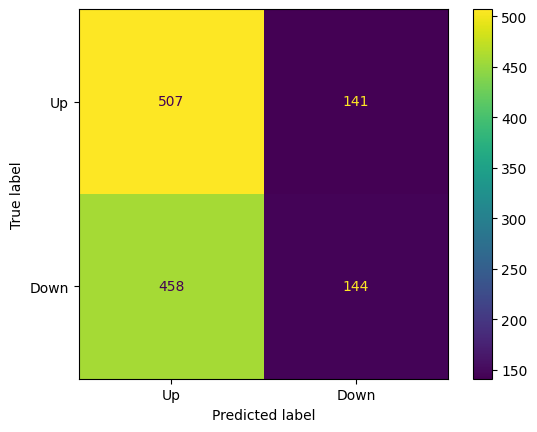

In [15]:

# 4. Analyze the Result

print(classification_report(y_true, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names)

### 2.4. Train Test Split

              precision    recall  f1-score   support

          No       0.98      0.99      0.99      1933
         Yes       0.68      0.31      0.43        67

    accuracy                           0.97      2000
   macro avg       0.83      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



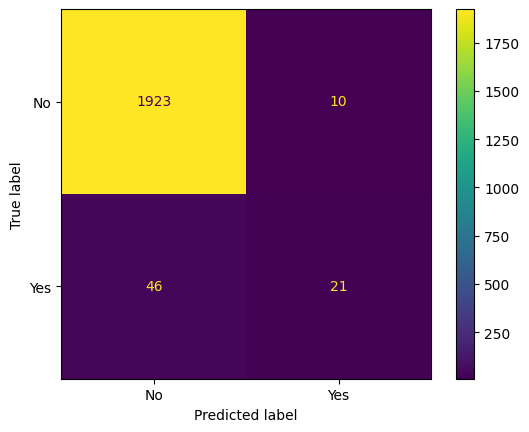

In [16]:
# Load and factorize data
df = pd.read_excel(f'{BASE_DIR}/Data/Default.xlsx')
df['default'], target_names = df['default'].factorize()
df['student'], _ = df['student'].factorize()

# Select X, Y
X = df[['balance']]
y = df['default']

# Train / Test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Train LogisticRegression model with train data
clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

# Predict test data with trained model
y_pred = clf.predict(X_test)
y_true = y_test

# Analyze Result
print(classification_report(y_true, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names)

### 2.5. Predict Probabilty of Default with Balance

In [17]:
X_train = df[['balance']]
y_train = df['default']

clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_train)

print('y_prob shape:', y_prob.shape)
print(y_prob)

y_prob shape: (10000, 2)
[[9.98694312e-01 1.30568789e-03]
 [9.97887393e-01 2.11260696e-03]
 [9.91405225e-01 8.59477452e-03]
 ...
 [9.97533473e-01 2.46652658e-03]
 [8.83240319e-01 1.16759681e-01]
 [9.99928552e-01 7.14482025e-05]]


### 2.6. Plot Balance - Probability Relationship

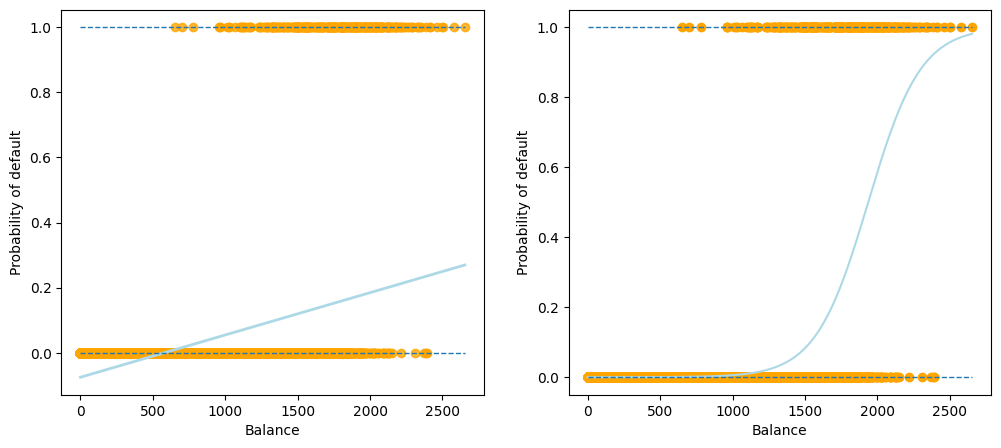

In [18]:
# Create array of test data
X_test = np.arange(df['balance'].min(), df['balance'].max()).reshape(-1,1)

# Calculate the classification probability for every balance values
y_prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Linear Regression (Left Plot)
sns.regplot(x=df['balance'], y=df['default'],
            order=1, ci=None, scatter_kws={'color':'orange'}, line_kws={'color':'lightblue', 'lw':2}, ax=ax1)

# Logistic Regression (Right plot)
ax2.scatter(X_train, y_train, color='orange')
ax2.plot(X_test, y_prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0], xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0], xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_xlabel('Balance')
    ax.set_ylabel('Probability of default')

### 2.7. Inside of the Library

#### 2.7.1. Scikit Learn

In [19]:
X_train = df[['balance']]
y_train = df['default']

clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

print(clf)
print('classes: ', clf.classes_)
print('coefficients: ', clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[0.00549891]]
intercept : [-10.6513194]


#### 2.7.2. Statsmodels

In [20]:
X_train = sm.add_constant(df[['balance']])
y_train = df['default']

est = Logit(y_train, X_train).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: default          Pseudo R-squared: 0.453      
Date:               2023-08-08 14:52 AIC:              1600.4517  
No. Observations:   10000            BIC:              1614.8724  
Df Model:           1                Log-Likelihood:   -798.23    
Df Residuals:       9998             LL-Null:          -1460.3    
Converged:          1.0000           LLR p-value:      6.2329e-290
No. Iterations:     10.0000          Scale:            1.0000     
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
const       -10.6513    0.3612  -29.4913  0.0000  -11.3592  -9.9435
balance       0.0055    0.0002   24.9524  0.0000    0.0051   0.0059
==================================================================

"""

### 2.8. Exercise
Write your code in the cells below. (5min)
1. Estimate Probability of `default` with `student` predictor
2. Check the inside of the library
3. Repeat 1~2 with Scikit Learn and Statsmodels

In [21]:
# with Scikit Learn

X_train = df[['student']]
y_train = df['default']

clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

print(clf)
print('classes: ', clf.classes_)
print('coefficients: ', clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[0.39959759]]
intercept : [-3.50213151]


In [22]:
# with Statsmodels

X_train = sm.add_constant(df[['student']])
y_train = df['default']

est = Logit(y_train, X_train).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.004     
Date:               2023-08-08 14:52 AIC:              2912.6831 
No. Observations:   10000            BIC:              2927.1037 
Df Model:           1                Log-Likelihood:   -1454.3   
Df Residuals:       9998             LL-Null:          -1460.3   
Converged:          1.0000           LLR p-value:      0.00054161
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const        -3.5041    0.0707  -49.5541  0.0000  -3.6427  -3.3655
student       0.4049    0.1150    3.5202  0.0004   0.1795   0.6303
=================================================================

"""

Get statistics with Scikit Learn
* https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
* https://datascience.stackexchange.com/questions/15398/how-to-get-p-value-and-confident-interval-in-logisticregression-with-sklearn

###  2.9. Multiple Logistic Regression (Balance, Income, Student - Default)
#### 2.9.1. Scikit Learn

In [23]:
X_train = df[['balance', 'income', 'student']]
y_train = df['default']

clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

print(clf)
print('classes: ', clf.classes_)
print('coefficients: ', clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[ 5.71870282e-03  3.52139581e-06 -6.22103567e-01]]
intercept : [-10.86431303]


#### 2.9.2. Statsmodels

In [24]:
X_train = df[['balance', 'income', 'student']]
y_train = df['default']

est = Logit(y_train, X_train).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.124277
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.149     
Date:               2023-08-08 14:52 AIC:              2491.5306 
No. Observations:   10000            BIC:              2513.1616 
Df Model:           2                Log-Likelihood:   -1242.8   
Df Residuals:       9997             LL-Null:          -1460.3   
Converged:          1.0000           LLR p-value:      3.2740e-95
No. Iterations:     9.0000           Scale:            1.0000    
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
balance       0.0028    0.0001   22.2911  0.0000   0.0025   0.0030
income       -0.0002    0.0000  -33.6716  0.0000  -0.0002  -0.0002
student      -3.7531    0.1527  -24.5803  0.0000  -4.0524  -3.4539
=================================================================

"""

#### 2.9.3. Exercise
Write your code in the cells below. (5min)
1. Load f'{BASE_DIR}/Data/Smarket.csv' data with pd.read_csv() method
2. Factorize 'Direction' Column
3. Show the relationship between various predictors (Use Statsmodels)

In [25]:
# 1. Load f'{BASE_DIR}/Data/Smarket.csv' data with pd.read_csv() method

df = pd.read_csv(f'{BASE_DIR}/Data/Smarket.csv')
df.head(3)

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down


In [26]:
# 2. Factorize 'Direction' Column

df['Direction'], target_names = df['Direction'].factorize()
print(target_names)
df.head(3)

Index(['Up', 'Down'], dtype='object')


,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,0
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,0
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,1


In [27]:
# 3. Show the relationship between various predictors (Use Statsmodels)

X_train = sm.add_constant(df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
y_train = df['Direction']

est = Logit(y_train, X_train).fit()
est.summary2()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Method:           MLE      
Dependent Variable: Direction        Pseudo R-squared: 0.002    
Date:               2023-08-08 14:52 AIC:              1741.5841
No. Observations:   1250             BIC:              1777.5004
Df Model:           6                Log-Likelihood:   -863.79  
Df Residuals:       1243             LL-Null:          -865.59  
Converged:          1.0000           LLR p-value:      0.73187  
No. Iterations:     4.0000           Scale:            1.0000   
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
const      0.1260     0.2407    0.5234   0.6007   -0.3458   0.5978
Lag1       0.0731     0.0502    1.4566   0.1452   -0.0253   0.1714
Lag2       0.0423     0.0501    0.8446   0.3984   -0.0559   0.1405
Lag3      -0.0111     0.0499   -0.2220   0.8243   -0.1090   0.0868
Lag4      -0.0094     0.0500   -0.1873   0.8514   -0.1073   0.0886
Lag5      -0.0103     0.0495   -0.2083   0.8350   -0.1074   0.0867
Volume    -0.1354     0.1584   -0.8553   0.3924   -0.4458   0.1749
================================================================

"""

### 2.11. Confounding in the *Default* data

In [28]:
# Load and factorize data
df = pd.read_excel(f'{BASE_DIR}/Data/Default.xlsx')
df['default'], target_names = df['default'].factorize()
df['student'], _ = df['student'].factorize()

# balance and default vectors for students
X_student = df[df['student'] == 1][['balance']]
y_student = df[df['student'] == 1]['default']

# balance and default vectors for non-students
X_not_student = df[df['student'] == 0][['balance']]
y_not_student = df[df['student'] == 0]['default']

# Test data for ploting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1, 1)

# Train the model and Predict Probabilities
clf_student = LogisticRegression(solver='newton-cg')
clf_student.fit(X_student, y_student)
prob_student = clf_student.predict_proba(X_test)

clf_not_student = LogisticRegression(solver='newton-cg')
clf_not_student.fit(X_not_student, y_not_student)
prob_not_student = clf_not_student.predict_proba(X_test)

In [29]:
df.groupby(['student','default']).size().unstack('default')

default,0,1
student,,
0,6850,206
1,2817,127


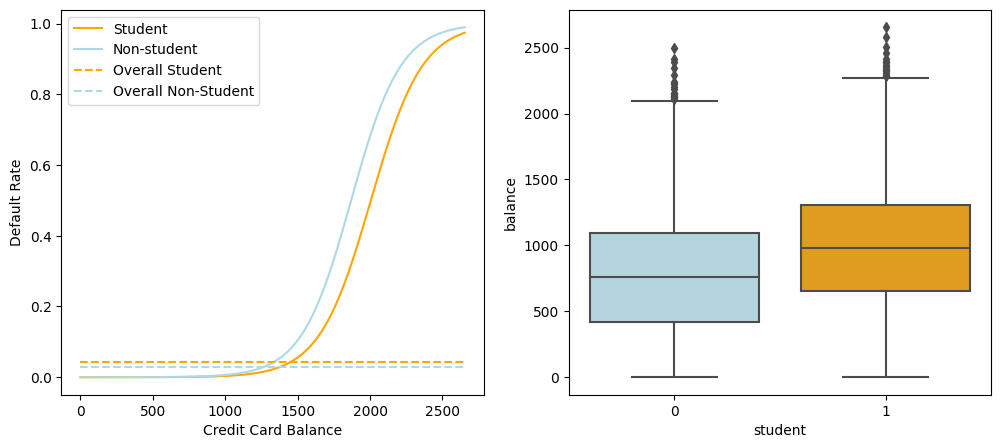

In [30]:
# Creating plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Left plot
ax1.plot(X_test, prob_student[:, 1], color='orange', label='Student')
ax1.plot(X_test, prob_not_student[:, 1], color='lightblue', label='Non-student')

default_prob_student = df[df['default'] == 1][df['student'] == 1].shape[0] / df[df['student'] == 1].shape[0]
default_prob_not_student = df[df['default'] == 1][df['student'] == 0].shape[0] / df[df['student'] == 0].shape[0]
ax1.hlines(default_prob_student,
           xmin=ax1.xaxis.get_data_interval()[0], xmax=ax1.xaxis.get_data_interval()[1],
           colors=['orange'], label='Overall Student', linestyles='dashed')
ax1.hlines(default_prob_not_student,
           xmin=ax1.xaxis.get_data_interval()[0], xmax=ax1.xaxis.get_data_interval()[1],
           colors=['lightblue'], label='Overall Non-Student', linestyles='dashed')
ax1.set_xlabel('Credit Card Balance')
ax1.set_ylabel('Default Rate')
ax1.legend(loc='upper left')

# Right plot
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot(df, x='student', y='balance', orient='v', ax=ax2,  palette=c_palette);

## 3. Linear Discriminant Analysis
### 3.1. Predict Default with LDA

In [31]:
X = df[['balance', 'income', 'student']]
y = df['default']

lda = LinearDiscriminantAnalysis()
y_pred = lda.fit(X, y).predict(X)
y_true = y

df_ = pd.DataFrame({'True default status': y_true,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)
df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



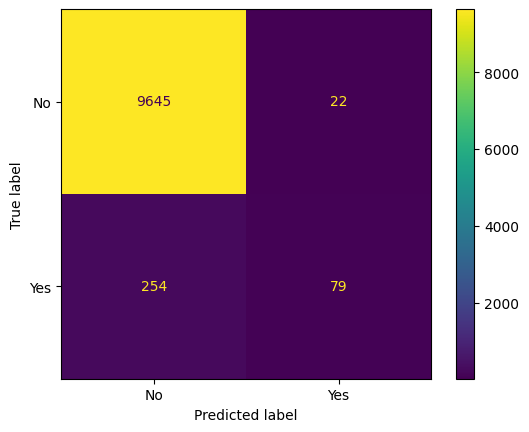

In [32]:
print(classification_report(y_true, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names)

In [33]:
FN_rate = np.sum(np.logical_and(y_pred == 0, y_true == 1)) / np.sum(y_true == 1)
FP_rate = np.sum(np.logical_and(y_pred == 1, y_true == 0)) / np.sum(y_true == 0)
error_rate = np.sum(y_pred != y_true) / y_pred.size

print(f'False Negative Rate: {FN_rate}')
print(f'False Positive Rate: {FP_rate}')
print(f'Error Rate: {error_rate}')

False Negative Rate: 0.7627627627627628
False Positive Rate: 0.0022757835936691837
Error Rate: 0.0276


### 3.2. Predict Default with Different Thresholds
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [34]:
decision_prob = 0.3  # Threshold
y_prob = lda.fit(X, y).predict_proba(X)
y_pred = y_prob[:, 1] > decision_prob
y_true = y

              precision    recall  f1-score   support

          No       0.98      0.99      0.99      9667
         Yes       0.61      0.46      0.52       333

    accuracy                           0.97     10000
   macro avg       0.80      0.72      0.75     10000
weighted avg       0.97      0.97      0.97     10000



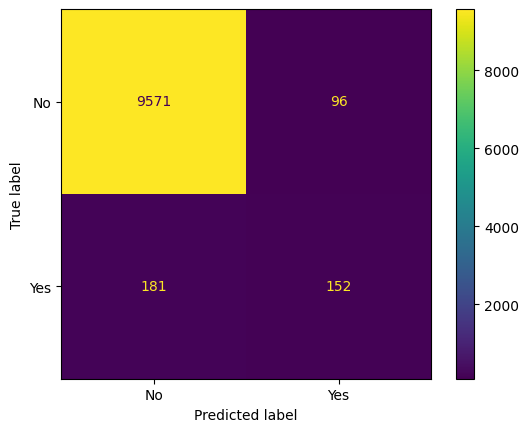

In [35]:
print(classification_report(y_true, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names)

In [36]:
FN_rate = np.sum(np.logical_and(y_pred == 0, y_true == 1)) / np.sum(y_true == 1)
FP_rate = np.sum(np.logical_and(y_pred == 1, y_true == 0)) / np.sum(y_true == 0)
error_rate = np.sum(y_pred != y_true) / y_pred.size

print(f'False Negative Rate: {FN_rate}')
print(f'False Positive Rate: {FP_rate}')
print(f'Error Rate: {error_rate}')

False Negative Rate: 0.5435435435435435
False Positive Rate: 0.009930692045101892
Error Rate: 0.0277


### 3.3. Exercise
Write your code in the cells below. (15min)
1. Calculate the False Negative Rate, False Positive Rate, Error Rate with various thresholds (0 ~ 0.5)
2. Plot a graph with 3 lines (X: Threadhold, y: FN, FP, Error)

In [37]:
# 1. Calculate the False Negative Rate, False Positive Rate, Error Rate with various thresholds (0 ~ 0.5)
thresholds = np.arange(0, 0.52, 0.01)

FN_rates, FP_rates, error_rates = [], [], []
for threshold in thresholds:
    y_pred = y_prob[:, 1] > threshold
    FN_rate = np.sum(np.logical_and(y_pred == 0, y_true == 1)) / np.sum(y_true == 1)
    FP_rate = np.sum(np.logical_and(y_pred == 1, y_true == 0)) / np.sum(y_true == 0)
    error_rate = np.sum(y_pred != y_true) / y_pred.size
    
    FN_rates.append(FN_rate)
    FP_rates.append(FP_rate)
    error_rates.append(error_rate)

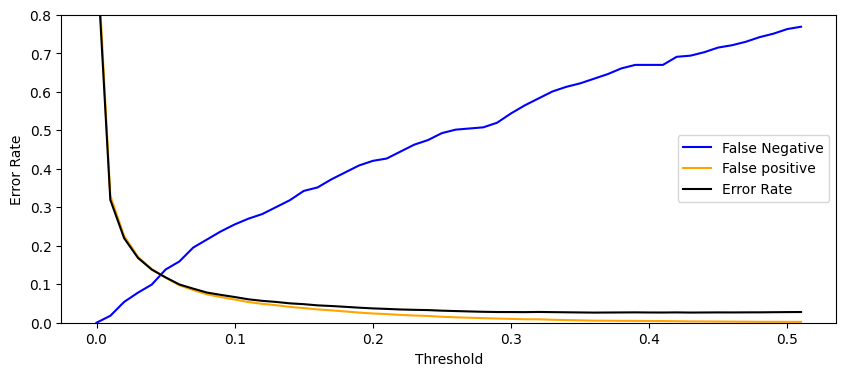

In [38]:
# 2. Plot a graph with 3 lines (X: Threadhold, y: FN, FP, Error)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, FN_rates, color='blue', label='False Negative')
ax.plot(thresholds, FP_rates, color='orange', label='False positive')
ax.plot(thresholds, error_rates, color='black', label='Error Rate')
ax.set_ylim(0, 0.8)
ax.set_xlabel('Threshold')
ax.set_ylabel('Error Rate')
ax.legend()
fig.show()

### 3.4. ROC curve

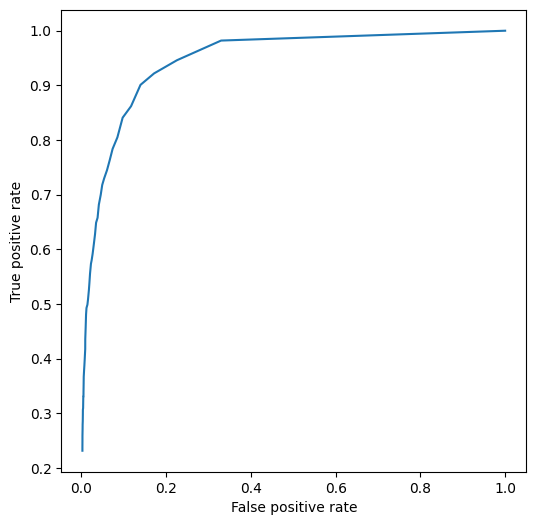

In [39]:
# Draw ROC curve

TP_rates = [1 - FN_rate for FN_rate in FN_rates]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(FP_rates, TP_rates)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
fig.show()

#### 3.4.1. ROC curve with Scikit Learn

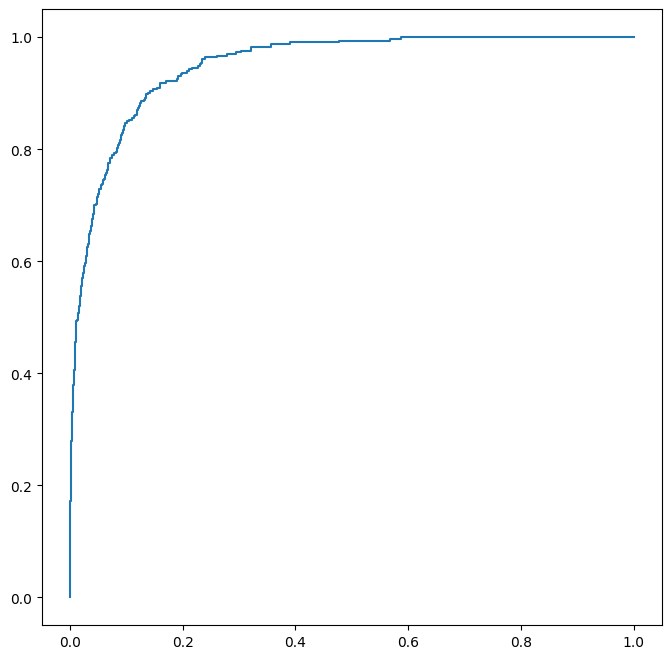

In [40]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1])

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr)
fig.show()

### 3.5. Area Under the Curve

In [41]:
auc_score = auc(fpr, tpr)
print(auc_score)

0.9495202246831501


In [42]:
auc_score = roc_auc_score(y_true, y_prob[:, 1])
print(auc_score)

0.9495202246831501


### 3.6. Advanced Exercise
Write your code in the cells below. (20min)
Plot ROC curve and AUC with *Hitters* Dataset.<br/>
Dataset Description: https://rdrr.io/cran/ISLR/man/Hitters.html
1. Load data (`f'{BASE_DIR}/Data/Hitters.csv'`)
2. Check Categorical Data
3. Preprocess Data (Drop NaN and Factorize)
4. Create New Label (Split High Salary and Low Salary)
5. Prepare Train data and Test data (Use all usable predictors)
6. Train and estimate the `y_pred`
7. Print classification report and plot confusion matrix
8. Estimate the `y_prob` with trained model
9. Plot ROC curve

#### 3.6.1. Load data (`f'{BASE_DIR}/Data/Hitters.csv'`)

In [43]:
pd.options.display.max_columns = None  # To show all columns
df = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv')
df.head(3)

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A


#### 3.6.2. Check Categorical Data

In [44]:
print(set(df['NewLeague']), set(df['League']), set(df['Division']))

{'A', 'N'} {'A', 'N'} {'E', 'W'}


#### 3.6.3. Preprocess Data (Drop NaN and Factorize)

In [45]:
df = df.dropna()
for column in ['NewLeague', 'League', 'Division']:
    df[column], _ = df[column].factorize()
df.head(3)

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0


#### 3.6.4. Create Label (Split High Salary and Low Salary)

In [46]:
median_salary = df['Salary'].median()
df['CategoricalSalary'] = (df['Salary'] > median_salary).astype(int)
df.head(3)

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,CategoricalSalary
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0,1
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1,1
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0,1


#### 3.6.5. Prepare Train data and Test data (Use all usable predictors)

In [47]:
predictors = list(set(df.columns) - {'CategoricalSalary', 'Salary', 'Unnamed: 0'})
X = df[predictors]
y = df['CategoricalSalary']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(197, 19) (66, 19) (197,) (66,)


#### 3.6.6. Train and estimate the `y_pred`

In [48]:
clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_true = y_test

#### 3.6.7. Print classification report and plot confusion matrix

              precision    recall  f1-score   support

         Low       0.78      0.85      0.82        34
        High       0.83      0.75      0.79        32

    accuracy                           0.80        66
   macro avg       0.81      0.80      0.80        66
weighted avg       0.81      0.80      0.80        66



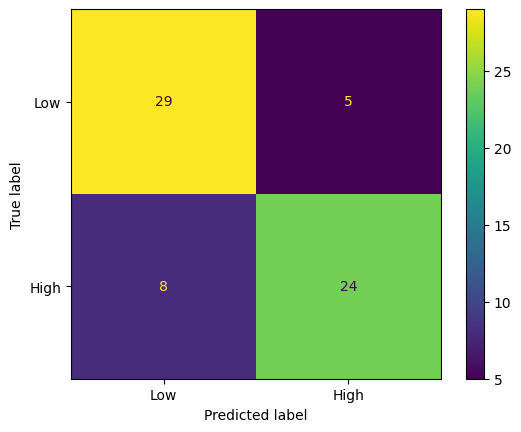

In [49]:
target_names = ['Low', 'High']
print(classification_report(y_true, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names)

#### 3.6.8. Estimate the `y_prob` with trained model

In [50]:
y_prob = clf.predict_proba(X_test)

#### 3.6.9. Plot ROC curve

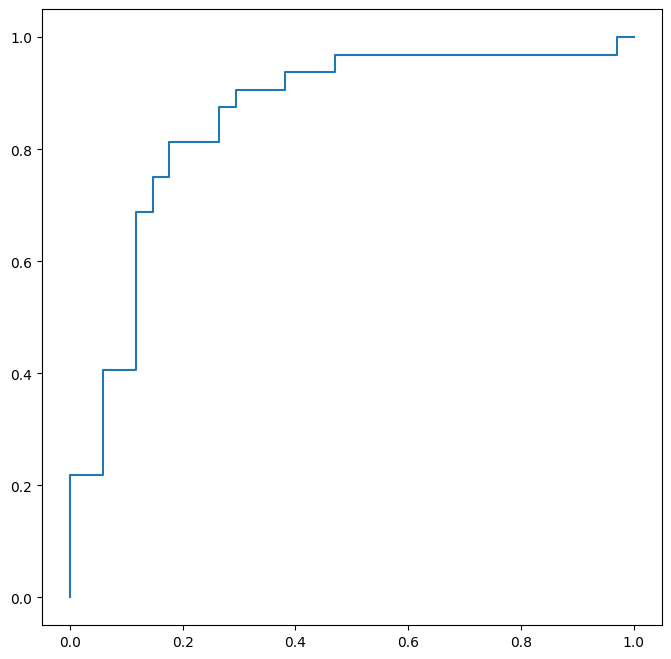

In [51]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1])

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr)
fig.show()

### 3.7. Dimensionality Reduction with LDA

<img src="https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main/Images/lda.png" style="width: 75%;"/>

#### 3.7.1. Load *Iris* Dataset

In [52]:
iris = load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

print(X.shape, y.shape, target_names)

(150, 4) (150,) ['setosa' 'versicolor' 'virginica']


#### 3.7.2 Dimensionality Reduction

In [53]:
pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(X, y).transform(X)

#### 3.7.3. Plot Data

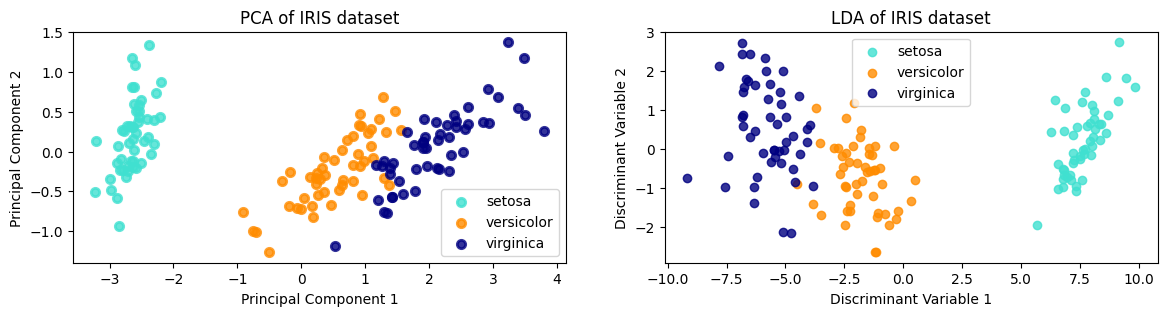

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,3))
colors = ['turquoise', 'darkorange', 'navy']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    PC1 = X_pca[y == i, 0]
    PC2 = X_pca[y == i, 1]
    ax1.scatter(PC1, PC2, color=color, alpha=0.8, lw=lw,
                label=target_name)
ax1.legend(loc='best', shadow=False, scatterpoints=1)
ax1.set_title('PCA of IRIS dataset')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    DV1 = X_lda[y == i, 0]
    DV2 = X_lda[y == i, 1]
    ax2.scatter(DV1, DV2, alpha=0.8, color=color,
                label=target_name)
ax2.legend(loc='best', shadow=False, scatterpoints=1)
ax2.set_title('LDA of IRIS dataset')
ax2.set_xlabel('Discriminant Variable 1')
ax2.set_ylabel('Discriminant Variable 2')

plt.show()

### 3.8. Inside the Library

In [55]:
df = pd.read_csv(f'{BASE_DIR}/Data/Smarket.csv', usecols=range(1, 10), index_col=0, parse_dates=True)
df.head(3)

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down


In [56]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
y_pred = lda.fit(X_train, y_train).predict(X_test)

In [57]:
lda.priors_, lda.means_, lda.coef_

(array([0.49198397, 0.50801603]),
 array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([[-0.05544078, -0.0443452 ]]))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



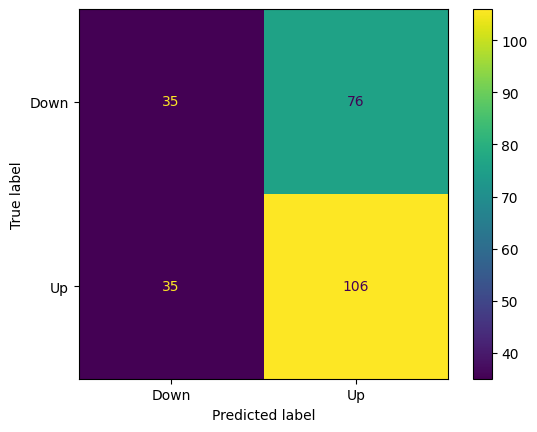

In [58]:
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=lda.classes_)

## 4. Different Classifiers
### 4.1. Quadratic Discriminant Analysis

In [59]:
df = pd.read_csv(f'{BASE_DIR}/Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
df.head(3)

X_train = df[:'2004'][['Lag1', 'Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1', 'Lag2']]
y_test = df['2005':]['Direction']

In [60]:
qda = QuadraticDiscriminantAnalysis()
y_pred = qda.fit(X_train, y_train).predict(X_test)

In [61]:
qda.priors_, qda.means_

(array([0.49198397, 0.50801603]),
 array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252



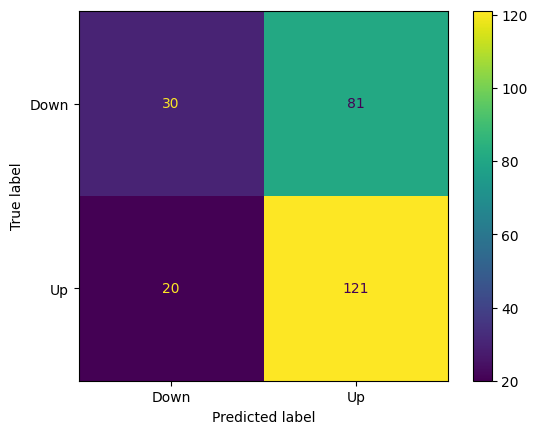

In [62]:
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=qda.classes_)

### 4.2. K-Nearest Neighbors

              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



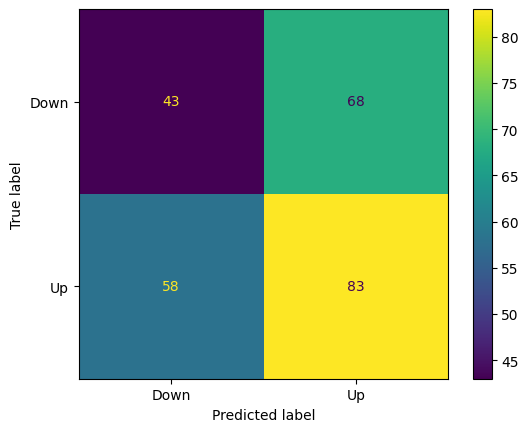

In [63]:
knn = KNeighborsClassifier(n_neighbors=1)
y_pred = knn.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=knn.classes_)

              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



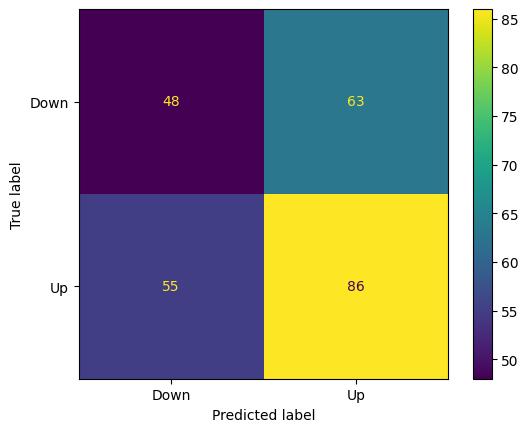

In [64]:
knn = KNeighborsClassifier(n_neighbors=3)
y_pred = knn.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=knn.classes_)

### 4.3. Naive Bayes Classifier

              precision    recall  f1-score   support

        Down       0.59      0.26      0.36       111
          Up       0.60      0.86      0.70       141

    accuracy                           0.60       252
   macro avg       0.59      0.56      0.53       252
weighted avg       0.59      0.60      0.55       252



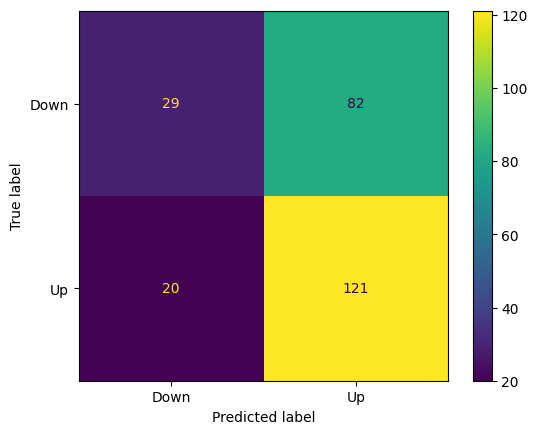

In [65]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=clf.classes_)

### 4.4. Exercise
Write your code in the cells below.
- Practice with the Caravan Insurance Dataset
- Data path: `f'{BASE_DIR}/Data/Caravan.csv'`
- Target Feature (y) : `Purchase`

In [66]:
df = pd.read_csv(f'{BASE_DIR}/Data/Caravan.csv')
df.head(3)

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,MINK123M,MINKGEM,MKOOPKLA,PWAPART,PWABEDR,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
2,3,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No


              precision    recall  f1-score   support

          No       0.94      1.00      0.97      1369
         Yes       0.50      0.02      0.04        87

    accuracy                           0.94      1456
   macro avg       0.72      0.51      0.51      1456
weighted avg       0.92      0.94      0.91      1456



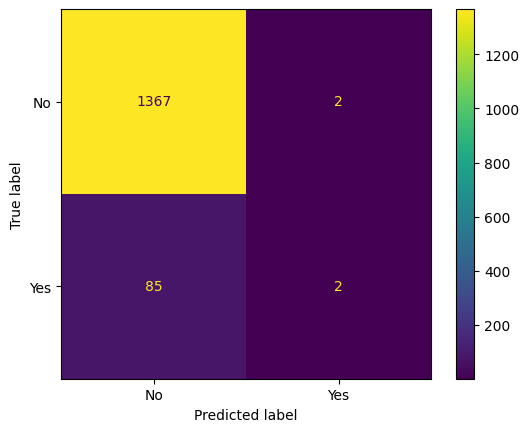

In [67]:
## Write Your code

X = df.drop(columns=['Unnamed: 0', 'Purchase'])
y = df['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=clf.classes_)